# Creating a Binary Classifier to Predict Voter Participation in Presidential Elections

## Final Project Submission

* Student name: Avonlea Fisher
* Student pace: full time
* Scheduled project review date/time: ue Oct 13, 2020 3pm - 3:45pm (EDT)
* Instructor name: James Irving
* Blog post URL: https://medium.com/@avfisher/creating-a-binary-classifier-to-predict-eligible-voter-participation-in-presidential-elections-9e882fc5da51

## Introduction 
The aim of this project is to build a binary classification model for predicting whether an eligible voter did not vote in the 2016 presidential election. It will use a selection of data from the [2018 General Social Survey](https://gss.norc.org/). Past research has suggested that socioeconomic variables such as education, wealth, and occupation are strong predictors of voter turnout. Features in this subset include a variety of socioeconomic variables, as well as variables related to respondents' political attitudes. 

The ability to predict if an eligible voter did not vote can be used to increase overall voter turnout in future elections. It is important to note that any model designed to predict human behavior is inherently limited, in that an individual's attitudes, motivations and circumstances can change within a given period of time—and especially over the course of an entire presidential term. Furthermore, there is a diversity of views about the value and efficacy of voting, and some eligible voters may abstatin from it on principle. This project does not assume that every non-voter can or should choose to vote, but is instead intented to serve only as a guideline for voter engagement organizations that are interested in focusing on likely non-voters.

## Exploring the Data

Let's load the data, display the first 5 rows, and examine the datatypes.

In [1]:
import pandas as pd
df_pre_encoded = pd.read_csv('GSS_2018.csv')
df_pre_encoded.head()

,Labor force status,Subjective class identification,Satisfaction with financial situation,Ever approve of police striking citizen,Should govt help pay for medical care?,Rs confidence in the existence of god,Rs health in general,Interested in environmental issues,Number of immigrants nowadays should be,Remember if voted in 2016 election,...,Age of respondent,Rs highest degree,Fathers highest degree,Mothers highest degree,Respondents sex,Race of respondent,Total family income,Did r vote in 2012 election,Think of self as liberal or conservative,Change abortion laws in r's state to make it easier or harder to get an abortion
0,Temp not working,Working class,Not at all sat,Not applicable,Not applicable,Know god exists,Good,Very interested,Remain the same as it is,Voted,...,43,Junior college,High school,High school,Male,White,Refused,Voted,Conservative,Make it harder
1,Retired,Working class,More or less,No,Agree with both,Know god exists,Not applicable,Not applicable,Not applicable,Voted,...,74,High school,Lt high school,Lt high school,Female,White,$25000 or more,Voted,Don't know,Stay the same as now
2,Working fulltime,Middle class,More or less,No,Agree with both,Believe but doubts,Very good,Very interested,Reduced a little,Voted,...,42,Bachelor,High school,Bachelor,Male,White,$25000 or more,Voted,Slghtly conservative,Make it harder
3,Working fulltime,Middle class,Satisfied,Yes,2,Know god exists,Excellent,Not applicable,Increased a little,Voted,...,63,Bachelor,Bachelor,High school,Female,White,Refused,Voted,Moderate,Stay the same as now
4,Retired,Upper class,Satisfied,Yes,Agree with both,Know god exists,Not applicable,Not applicable,Not applicable,Voted,...,71,Graduate,High school,High school,Male,Black,Refused,Voted,Extrmly conservative,Stay the same as now


In [2]:
df_pre_encoded.dtypes

Labor force status                                                                  object
Subjective class identification                                                     object
Satisfaction with financial situation                                               object
Ever approve of police striking citizen                                             object
Should govt help pay for medical care?                                              object
Rs confidence in the existence of god                                               object
Rs health in general                                                                object
Interested in environmental issues                                                  object
Number of immigrants nowadays should be                                             object
Remember if voted in 2016 election                                                  object
General happiness                                                                   object

Nearly all of the variables are nominal or ordinal, and will need to be numerically encoded for compatibility with a classification model.

In [3]:
#print number of rows and columns
df_pre_encoded.shape

(2350, 24)

We can inspect the value counts for each variable in the bar graphs below.

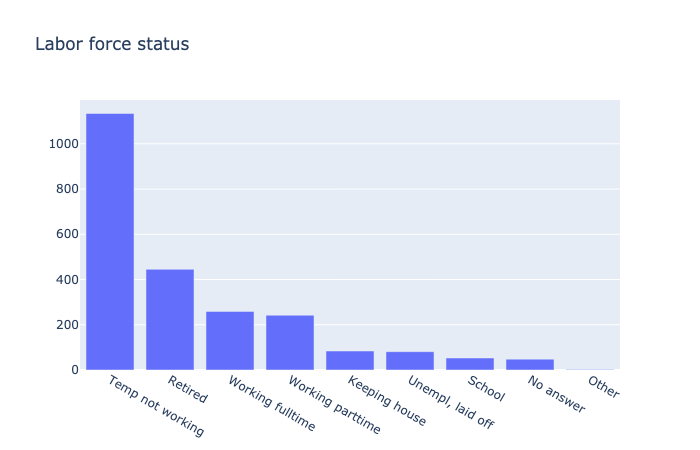

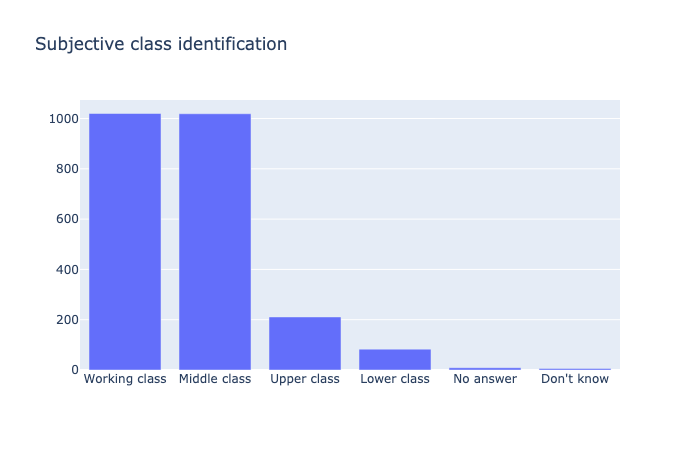

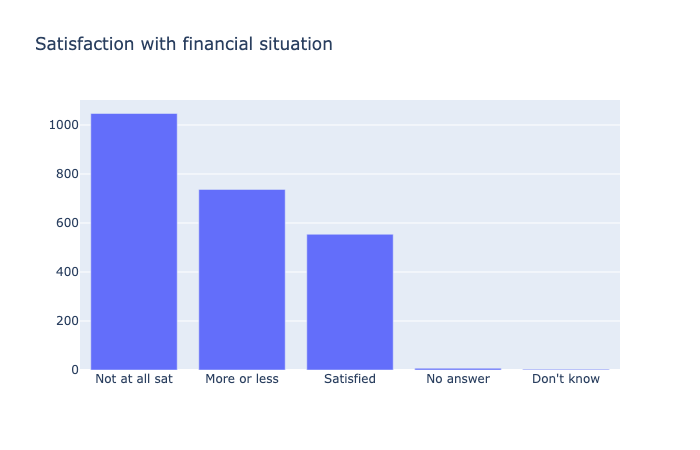

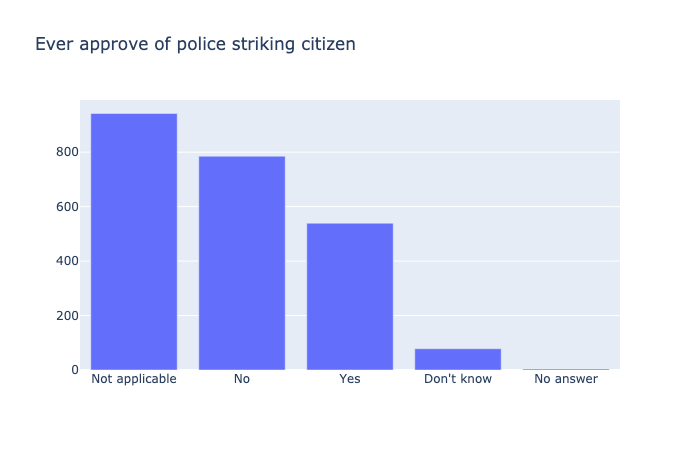

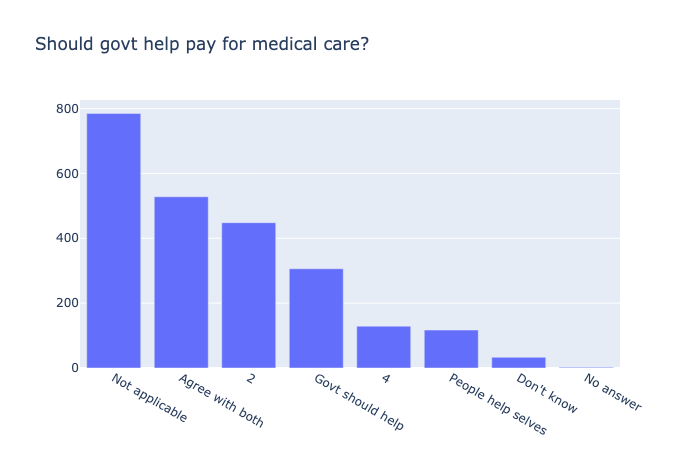

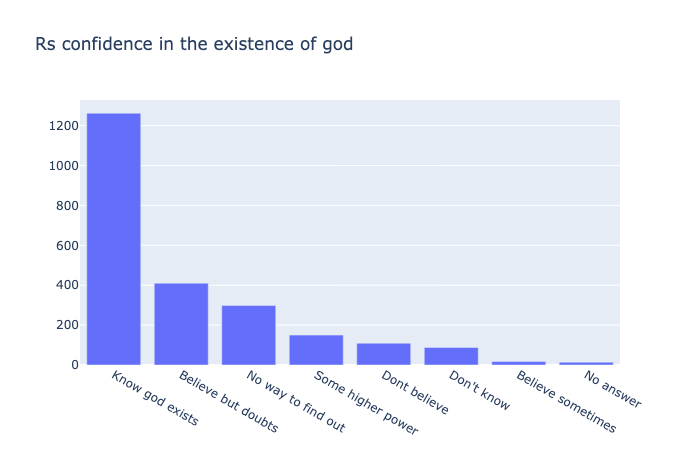

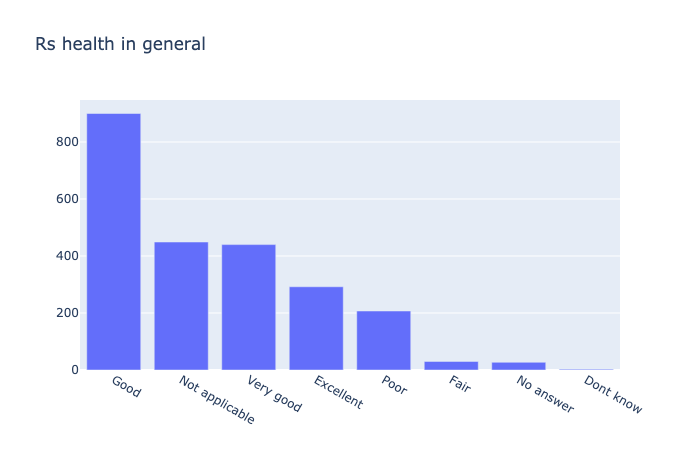

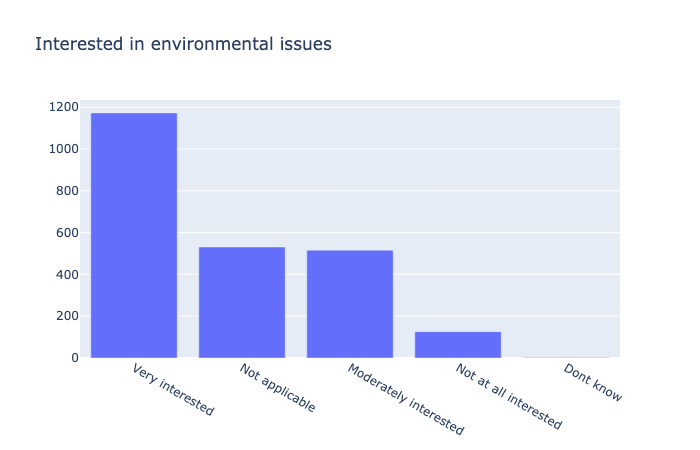

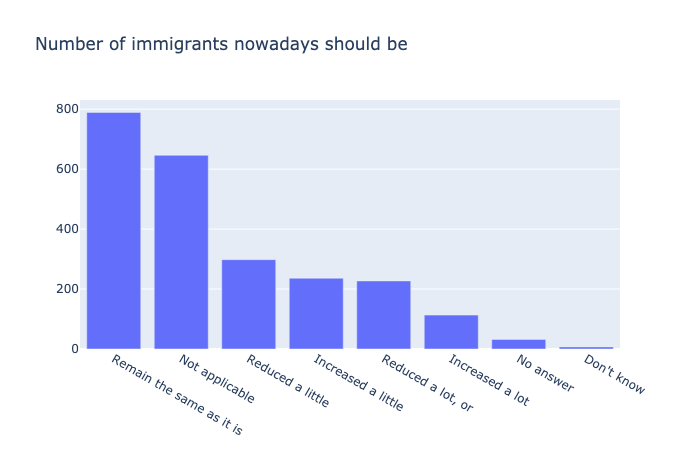

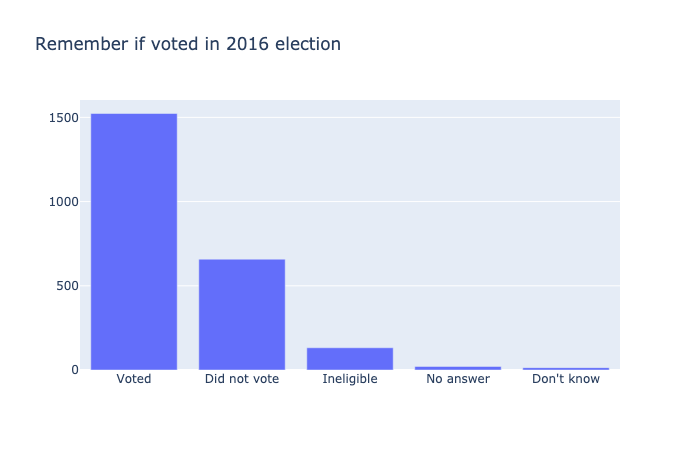

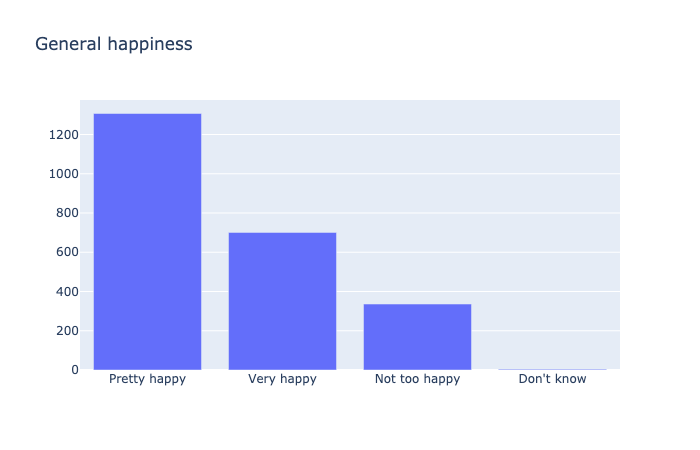

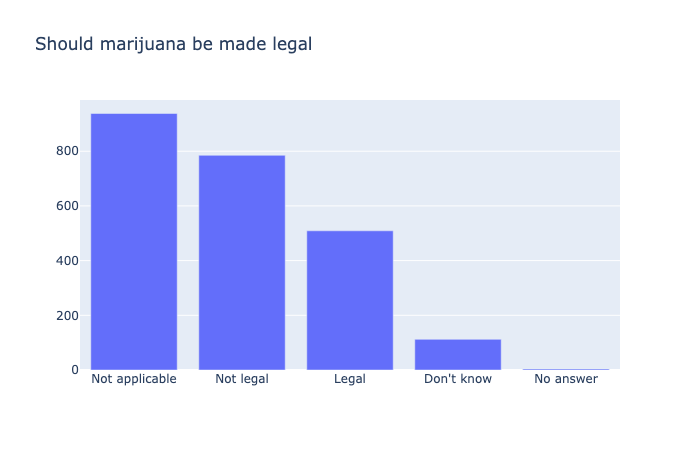

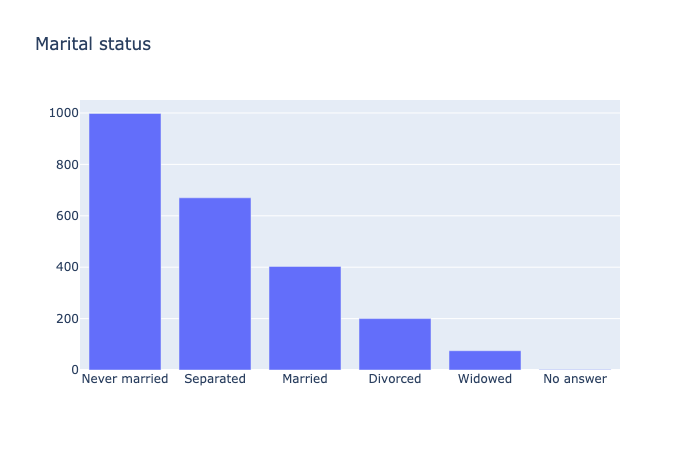

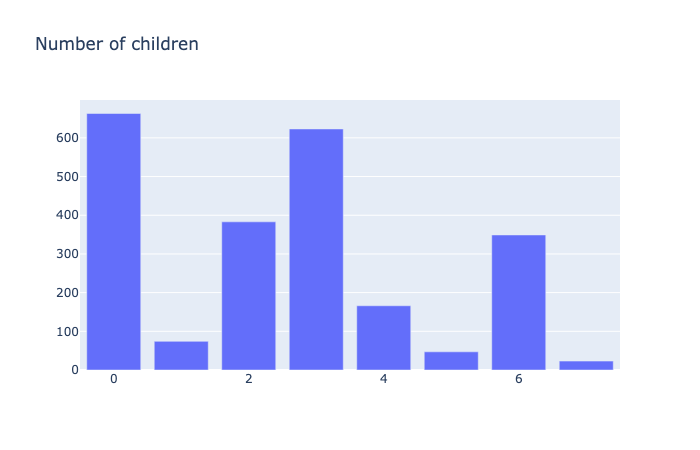

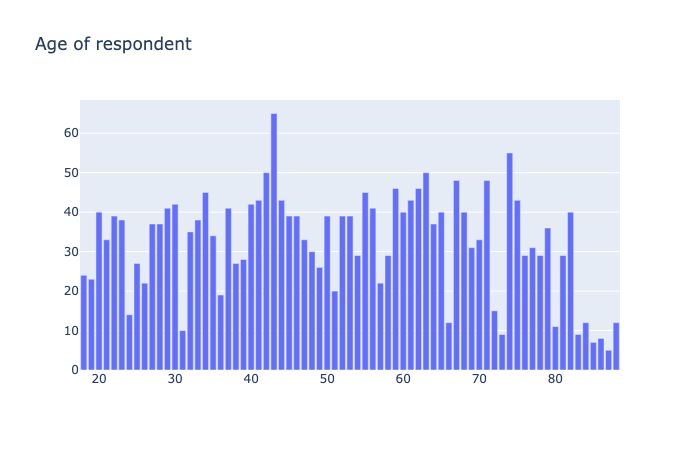

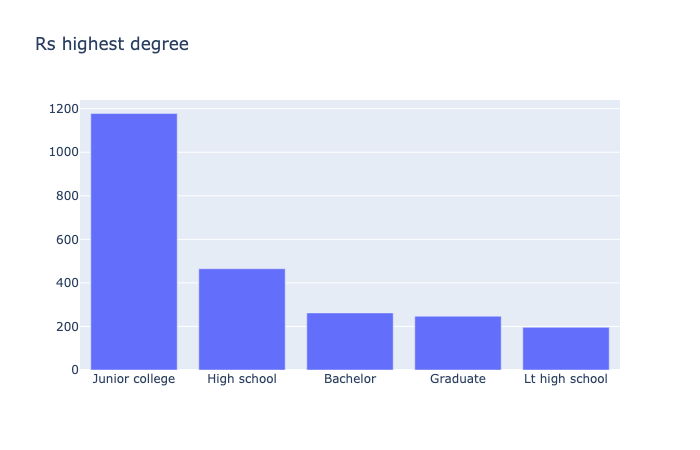

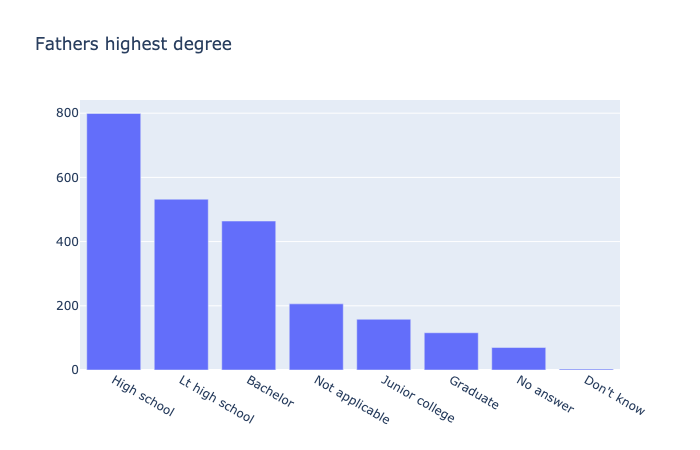

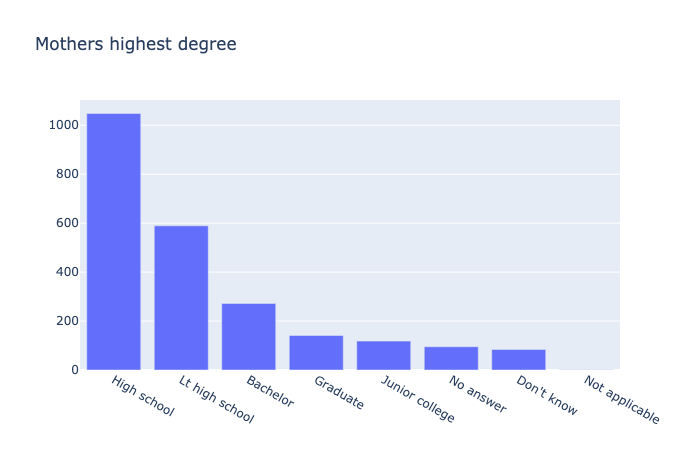

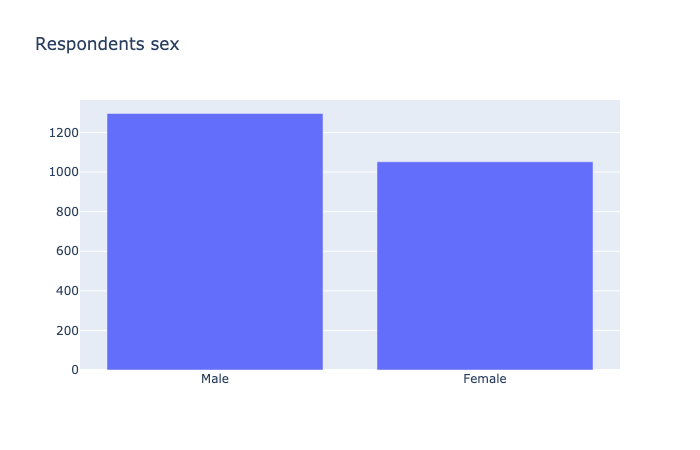

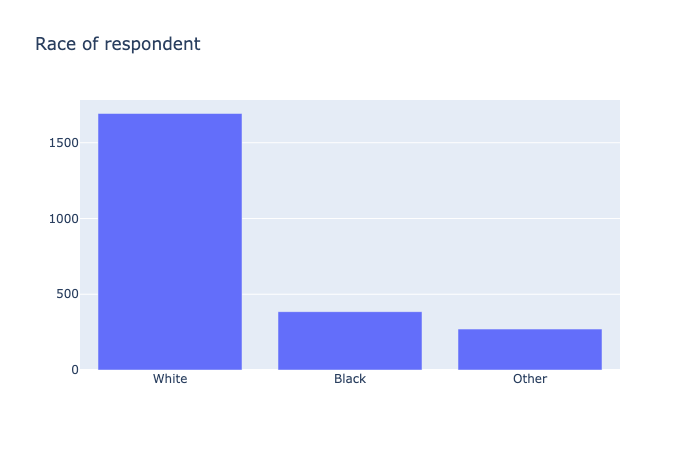

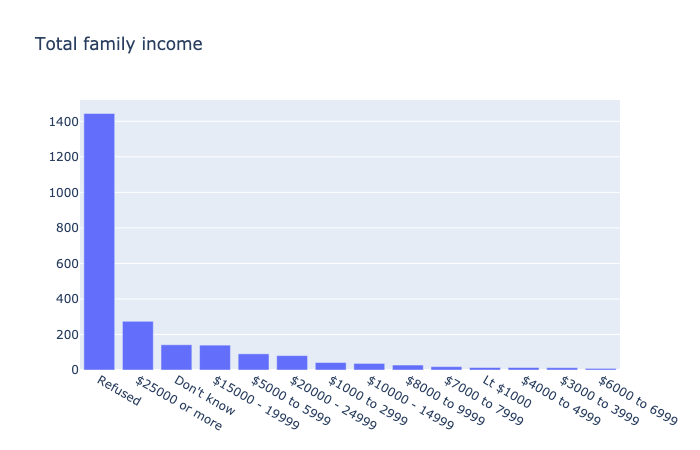

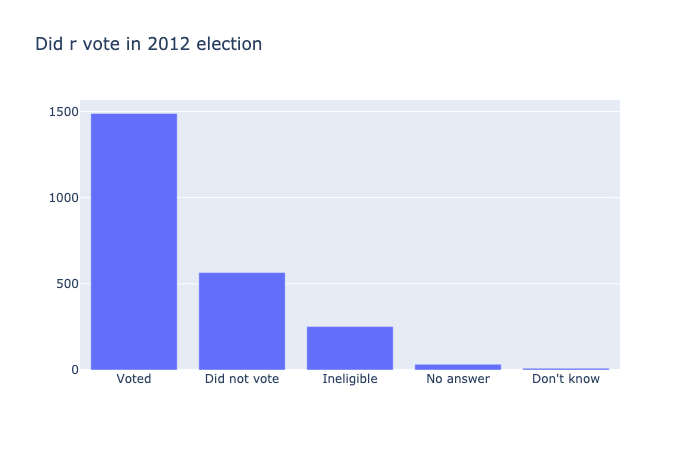

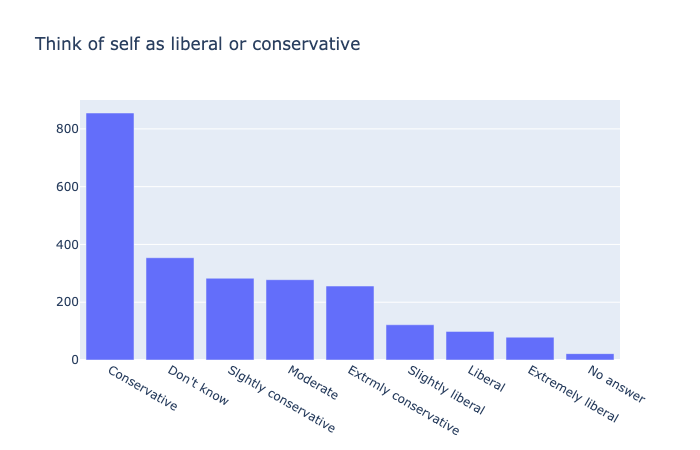

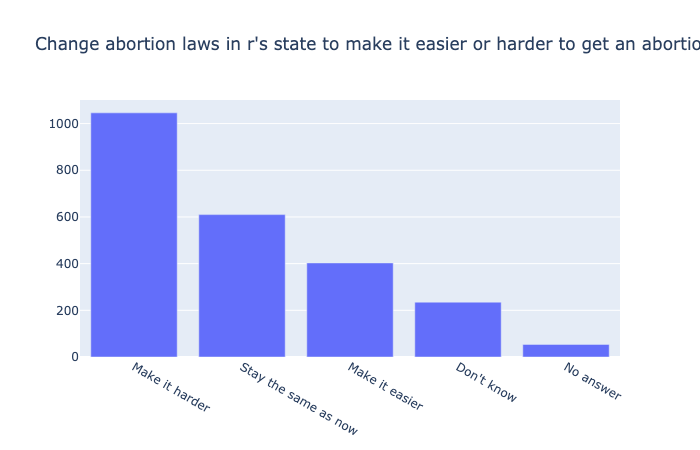

In [4]:
import plotly.graph_objects as go

for col in df_pre_encoded.columns.to_list():
    fig_dict = dict({
    "data": [{"type": "bar",
              "x": list(df_pre_encoded[col].unique()),
              "y": list(df_pre_encoded[col].value_counts())}],
    "layout": {"title": {"text": str(col)}}
})

    fig = go.Figure(fig_dict)

    fig.show("png")

With the exception of age, there are a limited number of unique values for each columm. Some columns are more balanced that others, which can be addressed by recoding the data where appropriate.

## Dealing with Missing Values

In the barplots above, we saw that there are some string values that signify missing or ambiguous data. Below, we update the dataframe to exclude such values. Some columns have a large percentage of "Not applicable" values. If more than 30% of a column's values are NA, we'll drop the column and print its name. Otherwise, we'll drop the rows.

In [5]:
vals_to_exclude = ["No answer", "Ineligible", "Don't know"]

for col in df_pre_encoded:
    df_pre_encoded = df_pre_encoded.loc[~df_pre_encoded[col].isin(vals_to_exclude)] 

    if (sum(df_pre_encoded[col] == 'Not applicable')/len(df_pre_encoded[col])) > .3:
        print(str(col))
        df_pre_encoded.drop(col, axis=1, inplace=True)
    else:
        df_pre_encoded = df_pre_encoded[df_pre_encoded[col] != "Not applicable"]

Ever approve of police striking citizen
Should govt help pay for medical care?
Rs health in general
Interested in environmental issues
Number of immigrants nowadays should be
Should marijuana be made legal


Now let's look at the total number of NA values in each column.

In [6]:
df_pre_encoded.isna().sum() 

Labor force status                                                                  1
Subjective class identification                                                     1
Satisfaction with financial situation                                               2
Rs confidence in the existence of god                                               2
Remember if voted in 2016 election                                                  2
General happiness                                                                   2
Marital status                                                                      2
Number of children                                                                  2
Age of respondent                                                                   2
Rs highest degree                                                                   2
Fathers highest degree                                                              2
Mothers highest degree                                

Since there are no more than two NA values in any column, rows containing NA values can be dropped.

In [7]:
df_pre_encoded.dropna(inplace=True)

In [8]:
df_pre_encoded.shape

(1083, 18)

We're left with 1,083 rows and 18 columns.

Before encoding the data, we'll make a copy of the pre-encoded dataframe to work with, in case we want to use the original data later.

In [9]:
df = df_pre_encoded.copy()

In [10]:
df_pre_encoded.dtypes

Labor force status                                                                  object
Subjective class identification                                                     object
Satisfaction with financial situation                                               object
Rs confidence in the existence of god                                               object
Remember if voted in 2016 election                                                  object
General happiness                                                                   object
Marital status                                                                      object
Number of children                                                                  object
Age of respondent                                                                   object
Rs highest degree                                                                   object
Fathers highest degree                                                              object

## Encoding the Data

Machine learning models require numeric data, but this data is almost exclusively categorical. Before testing any models on the data, we'll perform two types of encoding:

-  <b>Binary Encoding</b>: Some variables have only two values, and many of the nominal variables can be recoded as binary data. We'll do some custom encoding to simplify nominal variables with values that can be represented as binary. 
<br> <br>
-  <b>Integer Encoding</b>: For variables that have more than two ordinal values and cannot be recoded as binary, we'll assign each unique value an integer that corresponds to its ordinal position. This will make the encoded data easier to interpret.


### Binary Encoding 

#### Race and Sex

We'll create dummy variables for values in the race column, and drop the original column. We'll also drop one of the dummy columns, 'Other', to avoid the dummy variable trap. 

In [11]:
df = pd.get_dummies(df, columns=['Race of respondent'])
df.drop('Race of respondent_Other', axis=1, inplace=True)

While there are only two unique values for sex in the dataset, we'll reserve the the code '0' as a signifier of absence, and '1' as a signifier of the presence of a variable. Since neither 'male' nor 'female' signifies absence, it makes more sense to create dummy variables for both values, and then drop one of the columns.

In [12]:
df = pd.get_dummies(df, columns=['Respondents sex'])
df.drop('Respondents sex_Male', axis=1, inplace=True)

#### Voting

With voting, we're interested in predicting which respondents did not vote. Therefore, 'did not vote' will be encoded as '1', and 'voted' as '0'. The ```enc_col``` function below takes values, value codes, a column to encode, and a new name for the encoded column. It maps the codes onto values in the column, converts them to integers, and updates the column. The function also returns value counts for the new column.

In [13]:
def enc_col(vals, codes, col, new_col_name):
    
    """Takes in a tuple of values to encode, a tuple of numeric codes for the values, and a new column name. 
       Numerically encodes and renames the column. Returns the new column's value counts."""
    
    col_map = dict(zip(vals, codes))
    df[col] = df[col].map(col_map).astype('int64')
    df.rename(columns={col: new_col_name}, inplace=True)
    return df[new_col_name].value_counts()

In [14]:
vals = ('Voted', 'Did not vote')
codes = (0, 1)

enc_col(vals, codes, 'Remember if voted in 2016 election', "Didn't Vote in 2016")
enc_col(vals, codes, 'Did r vote in 2012 election', "Didn't Vote in 2012")

0    832
1    251
Name: Didn't Vote in 2012, dtype: int64

#### Labor Force Status

In the labor force column, there are 6 unique values, but they can be recoded as a binary variable that simply tells us whether a respondent is employed or not. We'll lose some nuance in the data, but creating a new variable for each value would result in many zero-inflated variables. This recoding method will ultimately result in more balanced data.

In [15]:
df['Labor force status'].unique()

array(['Temp not working', 'Working fulltime', 'Retired', 'Keeping house',
       'Working parttime', 'School', 'Unempl, laid off', 'Other'],
      dtype=object)

In [16]:
vals = ('Working fulltime', 'Working parttime', 
        'Retired', 'Keeping house', 'Temp not working', 'School', 'Unempl, laid off', 'Other')
codes = (0, 0, 
        1, 1, 1, 1, 1, 1)

enc_col(vals, codes, 'Labor force status', 'Employed')

0    672
1    411
Name: Employed, dtype: int64

#### Marital Status

Similarly, the marital status column can be recoded as 1 for 'has a marriage partner' and 0 for 'doesn't have a marriage partner'. The zero value will include those who are unmarried, divorced, widowed, or separated from their former marriage partner. 

In [17]:
df['Marital status'].unique()

array(['Never married', 'Married', 'Divorced', 'Widowed', 'Separated'],
      dtype=object)

In [18]:
vals = ('Never married', 'Divorced', 'Widowed', 'Separated',
       'Married')
codes = (0, 0, 0, 0, 
        1)

enc_col(vals, codes, 'Marital status', 'Has Marriage Partner')

1    549
0    534
Name: Has Marriage Partner, dtype: int64

#### Education Level of Parents

The education level of the respondent's mother and father can be recoded as 0="no college degree" and 1="college degree or higher."

In [19]:
df['Fathers highest degree'].value_counts()

High school       490
Lt high school    326
Bachelor          119
Graduate          101
Junior college     47
Name: Fathers highest degree, dtype: int64

In [20]:
df['Mothers highest degree'].value_counts()

High school       528
Lt high school    277
Bachelor          145
Junior college     75
Graduate           58
Name: Mothers highest degree, dtype: int64

In [21]:
vals = ('Lt high school', 'High school',
        'Junior college', 'Bachelor', 'Graduate')
codes = (0, 0, 
        1, 1, 1)

In [22]:
enc_col(vals, codes, 'Fathers highest degree', 'Father Attended College')

0    816
1    267
Name: Father Attended College, dtype: int64

In [23]:
enc_col(vals, codes, 'Mothers highest degree', 'Mother Attended College')

0    805
1    278
Name: Mother Attended College, dtype: int64

#### Family Income

The family income variable is highly imbalanced, with the majority of respondents reporting an income of $25,0000 or more. Let's look at the value counts again.

In [24]:
df['Total family income'].value_counts()

$25000 or more    756
Refused           132
$10000 - 14999     61
$20000 - 24999     46
$15000 - 19999     35
$8000 to 9999      15
Lt $1000           11
$5000 to 5999       7
$1000 to 2999       6
$3000 to 3999       5
$4000 to 4999       4
$6000 to 6999       3
$7000 to 7999       2
Name: Total family income, dtype: int64

Many respondents refused to report their income. This value can be filled with the mode, which won't improve the balance of the data, but is more likely to reflect the actual family incomes of respondents. Encoding all other values as 0 should improve the imbalance slightly.

In [25]:
vals = ('$15000 - 19999', '$5000 to 5999','$20000 - 24999', '$1000 to 2999', '$10000 - 14999', '$8000 to 9999', 
        '$7000 to 7999', 'Lt $1000', '$4000 to 4999','$3000 to 3999', '$6000 to 6999',
       '$25000 or more', 'Refused')
codes = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1)

enc_col(vals, codes, 'Total family income', 'Fam Income Above 25k')

1    888
0    195
Name: Fam Income Above 25k, dtype: int64

### Integer Encoding

Some variables in the dataset have an order and can be encoded accordingly with integers higher than 1. 

#### Age

Age, for example, has string values between '24' and '89 or older'. 

In [26]:
print(df['Age of respondent'].min(), ',',
      df['Age of respondent'].max())

24 , 89 or older


We could simply convert all of these values to integers, but given that all other variables have values that don't exceed a single digit, age could be weighed more heavily in the model. Instead, we'll create evenly spaced age ranges and assign each value within the range to a number between 0 and 6. Respondents in their 20s will be encoded as '1', 30s as '2', and so on.

First, we'll change the '89 or older' string to the integer 89.

In [27]:
df.loc[(df['Age of respondent'] == '89 or older'),'Age of respondent']= 89

In [28]:
for age in df['Age of respondent']:
    if  19 < int(age) <= 29:
        df.loc[(df['Age of respondent'] == age),'Age of respondent']= 1
    if  29 < int(age) <= 39:
        df.loc[(df['Age of respondent'] == age),'Age of respondent']= 2
    if  39 < int(age) <= 49:
        df.loc[(df['Age of respondent'] == age),'Age of respondent']= 3
    if  49 < int(age) <= 59:
        df.loc[(df['Age of respondent'] == age),'Age of respondent']= 4
    if  59 < int(age) <= 69:
        df.loc[(df['Age of respondent'] == age),'Age of respondent']= 5
    if  69 < int(age) <= 79:
        df.loc[(df['Age of respondent'] == age),'Age of respondent']= 6
    if  79 < int(age) <= 89:
        df.loc[(df['Age of respondent'] == age),'Age of respondent']= 7

df['Age Category (Young-Old)'] = pd.to_numeric(df['Age of respondent'])
df.drop('Age of respondent', axis =1, inplace=True)

#### Respondent's Belief in Higher Power

This variable can be treated as ordinal, if we think of the values as lying on a scale between not believing (0), maybe believing (1), and definitely believing (2) in a higher power. 

In [29]:
vals = ('Dont believe', 'No way to find out',
        'Believe but doubts', 'Believe sometimes',
        'Know god exists', 'Some higher power')
codes = (0, 0, 
         1, 1,
         2, 2)

enc_col(vals, codes, 'Rs confidence in the existence of god', 'Strength of Belief in Higher Power')

2    713
1    233
0    137
Name: Strength of Belief in Higher Power, dtype: int64

#### Subjective Class Identification

For this variable, each class will be assigned to an integer that falls on a range from 'lower class' to 'upper class.' 

In [30]:
vals = ('Lower class','Working class', 'Middle class', 'Upper class')
codes = (1, 2, 3, 4)

enc_col(vals, codes, 'Subjective class identification', 'Class ID (Lower-Upper Class)')

3    539
2    422
1     77
4     45
Name: Class ID (Lower-Upper Class), dtype: int64

We'll apply this function to encode other ordinal variables similarly.

#### Satisfaction with financial situation

In [31]:
df["Satisfaction with financial situation"].unique()

array(['Not at all sat', 'More or less', 'Satisfied'], dtype=object)

In [32]:
vals = ('Not at all sat', 'More or less', 'Satisfied')
cols = (1, 2, 3)

enc_col(vals, codes, 'Satisfaction with financial situation', "Level of Financial Satisfaction" )

2    488
3    376
1    219
Name: Level of Financial Satisfaction, dtype: int64

#### Respondent's Level of Education

In [33]:
vals = ('Lt high school', 'High school', 'Junior college', 'Bachelor', 'Graduate')
codes = (1, 2, 3, 4, 5) 

enc_col(vals, codes, 'Rs highest degree', "Level of R's Education")

2    485
4    282
5    150
3     91
1     75
Name: Level of R's Education, dtype: int64

#### Conservative/Liberal Scale

In [34]:
vals = ('Extrmly conservative', 'Conservative', 'Slghtly conservative', 'Moderate',
       'Slightly liberal', 'Liberal', 'Extremely liberal')
codes = (1, 2, 3, 4, 5, 6, 7) 

enc_col(vals, codes, 'Think of self as liberal or conservative', 'Political ID (More Conservative-More Liberal)')

4    366
2    185
3    143
6    142
5    133
1     58
7     56
Name: Political ID (More Conservative-More Liberal), dtype: int64

#### Number of children

In [35]:
vals = ('0', '1', '2', '3', '4', '5', '6', '7', 'Eight or more')
codes = (0, 1, 2, 3, 4, 5, 6, 7, 8) 

enc_col(vals, codes, 'Number of children', 'Number of Children')

2    323
0    271
3    180
1    155
4     82
5     34
6     21
7     10
8      7
Name: Number of Children, dtype: int64

#### Views on Abortion 

In [36]:
df["Change abortion laws in r's state to make it easier or harder to get an abortion"].unique()

array(['Make it harder', 'Stay the same as now', 'Make it easier'],
      dtype=object)

In [37]:
vals = ('Make it easier', 'Stay the same as now', 'Make it harder')
codes = (1, 2, 3)

enc_col(vals, codes, 
        "Change abortion laws in r's state to make it easier or harder to get an abortion",
       "Change Abortion Access Laws (Easier-Harder)")

2    540
3    333
1    210
Name: Change Abortion Access Laws (Easier-Harder), dtype: int64

#### General Happiness

In [38]:
df['General happiness'].unique()

array(['Pretty happy', 'Very happy', 'Not too happy'], dtype=object)

In [39]:
vals = ('Not too happy', 'Pretty happy', 'Very happy')
codes = (1, 2, 3)

enc_col(vals, codes, 'General happiness','General happiness')

2    594
3    353
1    136
Name: General happiness, dtype: int64

### Final Encoded Data

Let's take a look at our final dataframe after encoding.

In [40]:
df.dtypes

Employed                                         int64
Class ID (Lower-Upper Class)                     int64
Level of Financial Satisfaction                  int64
Strength of Belief in Higher Power               int64
Didn't Vote in 2016                              int64
General happiness                                int64
Has Marriage Partner                             int64
Number of Children                               int64
Level of R's Education                           int64
Father Attended College                          int64
Mother Attended College                          int64
Fam Income Above 25k                             int64
Didn't Vote in 2012                              int64
Political ID (More Conservative-More Liberal)    int64
Change Abortion Access Laws (Easier-Harder)      int64
Race of respondent_Black                         uint8
Race of respondent_White                         uint8
Respondents sex_Female                           uint8
Age Catego

In our encoded dataset, all variables are numeric and on similar scales. Zero indicates the absence of a variable,  and with integer-encoded variables, higher values indicate that more of the variable is present. 

### Feauture Correlations

Many models assume that there is little to no multicollinearity in the data. Using .75 as the cutoff for our correlation coefficient, we'll examine variable correlations on the matrix below.

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations', fontsize=30, y=.95, fontname='Silom')
heatmap = sns.heatmap(corr, cmap='Purples', annot=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
heatmap

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



The correlation matrix shows that there are relatively weak correlations between most variables. No correlation coefficient exceeds the .75 cutoff, so we won't have to exclude any more columns before building a model.

### Visualizing Voter Turnout Rates by Feature

It appears that, by far, the most highly correlated feature was whether a respondent voted in the previous election. With the functions below, we can visualize the percentage of voters across categories in the most important features. The first function takes a feature column, and calculates the percentage of 2016 voters for each unique value in the column:

In [42]:
df.columns

Index(['Employed', 'Class ID (Lower-Upper Class)',
       'Level of Financial Satisfaction', 'Strength of Belief in Higher Power',
       'Didn't Vote in 2016', 'General happiness', 'Has Marriage Partner',
       'Number of Children', 'Level of R's Education',
       'Father Attended College', 'Mother Attended College',
       'Fam Income Above 25k', 'Didn't Vote in 2012',
       'Political ID (More Conservative-More Liberal)',
       'Change Abortion Access Laws (Easier-Harder)',
       'Race of respondent_Black', 'Race of respondent_White',
       'Respondents sex_Female', 'Age Category (Young-Old)'],
      dtype='object')

In [43]:
def voter_perc_dict(col):
    
    """Takes in a column in the dataframe. Returns a dictionary with the proportion of voters for each unique 
       value of the column."""
    
    col_dict = {}
    for val in df[col].unique():
        respondents_with_val = df[df[col] == val]
        voters_with_val = respondents_with_val[respondents_with_val["Didn't Vote in 2016"]==0]
        perc_of_voters = round(len(voters_with_val)/len(respondents_with_val) * 100, 1)
        col_dict[val] = perc_of_voters
    return col_dict

Let's test the function on a column:

In [44]:
voter_perc_dict('Respondents sex_Female')

{0: 76.4, 1: 76.8}

76.8% of female respondents voted in 2016, while 76.4% of male respondents voted. Now, we'll use this function within the ```plot_voter_perc``` function which makes a barplot of the dictionary, given a column, a title for the plot, and a list of xtick labels.

In [45]:
def plot_voter_perc(col, title, xtick_labs):
    
    """Takes in a column, a bar plot title, and a list of x-tick labels. Returns an 8x6 bar plot 
       of voter percentages for each unique value of the column, with percentages on the y-axis."""
    
    voter_perc = voter_perc_dict(col)
    
    plt.figure(figsize=(8,6))
    
    sns.barplot(x=list(voter_perc.keys()), y=list(voter_perc.values()))
    plt.ylabel("Percentage of Respondents who Voted in 2016", fontsize=12)
    plt.title(title, fontname='silom')
        
    locs, labels=plt.xticks()
    x_ticks = []
    new_xticks= xtick_labs
    plt.xticks(locs,new_xticks, rotation=35, horizontalalignment='right')
    plt.plot()

Now let's use this function on the top 6 features that are most highly correlated with voting in 2016.

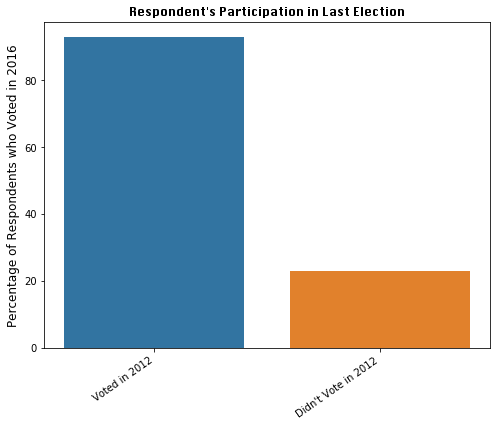

In [46]:
xtick_labs = ["Voted in 2012", "Didn't Vote in 2012"]

plot_voter_perc("Didn't Vote in 2012", "Respondent's Participation in Last Election", xtick_labs)

The vast majority of respondents who voted in 2012 also voted in 2016, while just over 20% of those who didn't vote in 2012 voted in 2016.

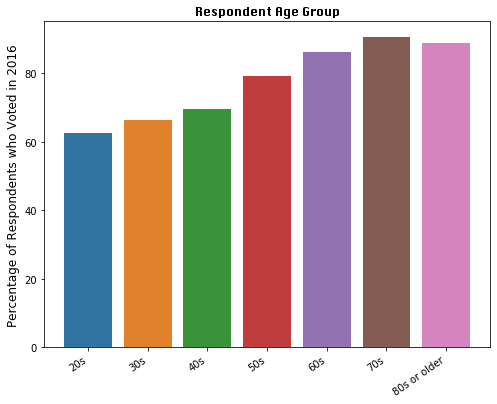

In [47]:
xtick_labs = ["20s", "30s", "40s", "50s", "60s", "70s", "80s or older"]

plot_voter_perc("Age Category (Young-Old)", "Respondent Age Group", xtick_labs)

The percentage of voters appears to increase steadily as age increases, with a slight decline after voters reach their 80s.

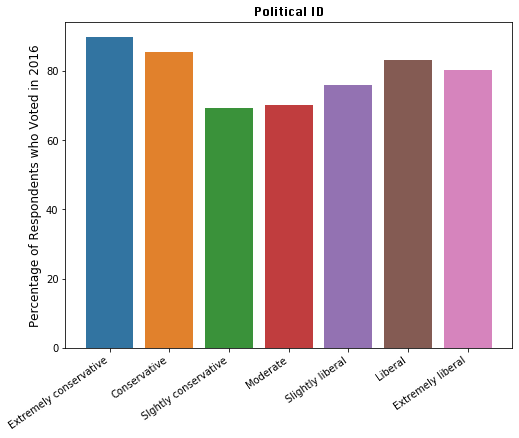

In [48]:
xtick_labs = ['Extremely conservative', 'Conservative', 'Slghtly conservative', 'Moderate',
                'Slightly liberal', 'Liberal', 'Extremely liberal']

plot_voter_perc("Political ID (More Conservative-More Liberal)", "Political ID", xtick_labs)

Conservative and liberal voters appear to have had a higher voter turnout than political moderates.

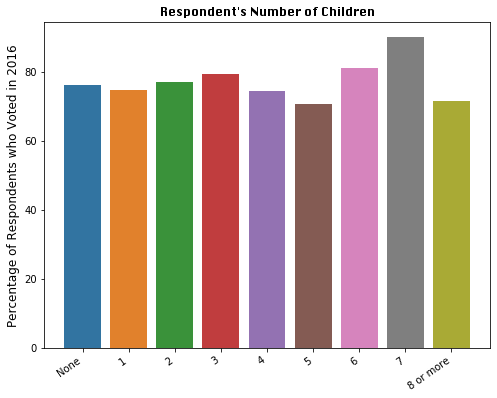

In [49]:
xtick_labs = ["None", "1", "2", "3", "4", "5", "6", "7", "8 or more"]

plot_voter_perc("Number of Children", "Respondent's Number of Children", xtick_labs)

There is not as much of a clear relationship here, but respondents with 6 and 7 children appear to have the highest turnout.

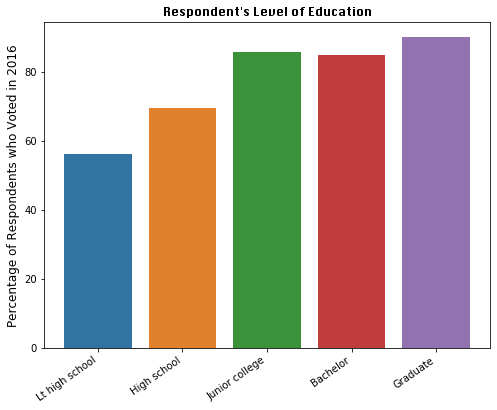

In [50]:
xtick_labs = ['Lt high school', 'High school', 'Junior college', 'Bachelor', 'Graduate']

plot_voter_perc("Level of R's Education", "Respondent's Level of Education", xtick_labs)

Voter turnout rates appear to increase as respondents' level of education increases.

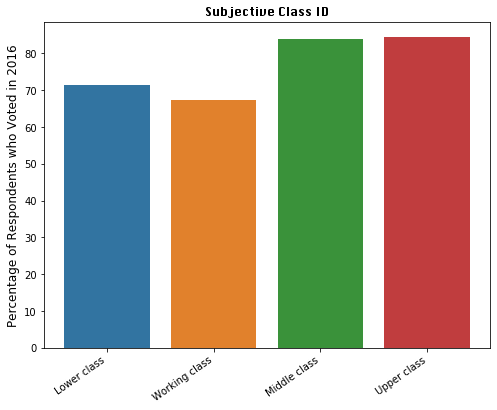

In [51]:
xtick_labs = ['Lower class','Working class', 'Middle class', 'Upper class']

plot_voter_perc("Class ID (Lower-Upper Class)", "Subjective Class ID", xtick_labs)

Middle and upper class respondents had higher turnout rates than those who identify as lower or working class.

## Building a Classification Model

### Splitting the Data

Now that the data has been cleaned and encoded, we can create new independent and dependent datasets. Our dependent variable is voting in the 2016 election, and all other variables in the dataframe are independent.

In [52]:
X = df.drop(columns=["Didn't Vote in 2016"], axis=1)
y = df["Didn't Vote in 2016"]

In [53]:
X.head()

,Employed,Class ID (Lower-Upper Class),Level of Financial Satisfaction,Strength of Belief in Higher Power,General happiness,Has Marriage Partner,Number of Children,Level of R's Education,Father Attended College,Mother Attended College,Fam Income Above 25k,Didn't Vote in 2012,Political ID (More Conservative-More Liberal),Change Abortion Access Laws (Easier-Harder),Race of respondent_Black,Race of respondent_White,Respondents sex_Female,Age Category (Young-Old)
0,1,2,1,2,2,0,0,3,0,0,1,0,2,3,0,1,0,3
2,0,3,2,1,3,1,2,4,0,1,1,0,3,3,0,1,0,3
3,0,3,3,2,3,1,2,4,1,0,1,0,4,2,0,1,1,5
4,1,4,3,2,2,0,0,5,0,0,1,0,1,2,1,0,0,6
8,0,1,1,1,1,0,4,1,0,0,0,0,4,2,0,1,1,5


With these datsets, we can split the data into training and test sets using ```train_test_split```.

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10, test_size=.3)

In [55]:
#print shape of training and test sets
print('Training:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Training: (758, 18) (758,)
Test: (325, 18) (325,)


### Scoring and Optimization Process

There are a variety of metrics that can be used to evaluate the performance of a binary classification model. They include:
-  <b> Accuracy: </b> the number of correctly predicted values over the total number of predictions
-  <b> Precision: </b> the number of true positives over the number of positive predictions
-  <b> Recall: </b> the number of true positives over the number of actual positives
-  <b> F1 Score: </b> a metric that balances precision and recall

All of these metrics fall between 0 and 1, with higher values indicating a better score. The metric that we're most interested in maximizing is recall, or the true positive rate. For this project's purposes, correctly identifying individuals who didn't vote is more important than identifying those who did vote. 

Given that the classes in Y are unbalanced (most people voted), we can expect our models to have a high accuracy score, but it would be misleading to rely on this metric. Where possible, we'll address the <b>class imbalance</b> of the dependent variable by assigning a balanced weight to the classes.
<br>
<br>
For each model type, we'll begin by plotting a baseline model with the default parameters passed in. Then, we'll search for the best parameters to optimize the model. After testing a few different model types, we'll decide which optimized model had the best performance and select it as the final model. 

### Logistic Regression

Logistic regression can be used when the Y-variable is dichotomous and when observations are independent. The model uses probability to predict class membership.

#### Baseline

In [57]:
#fit a logistic regression model with default parameters to the data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced', random_state=10)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=10)

Since we'll create a confusion matrix for multiple models, we'll use the function below to create it automatically. In addition to plotting a confusion matrix, the function displays accuracy, precision, recall and F1 scores next to the plot.

In [58]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def plot_cm(model, model_type):
    
    """Takes in a fitted sklearn binary classifier and strings for the the model type. Returns a 7x5 
       confusion matrix with accuracy, precision, recall and F1 scores plotted next to the matrix."""
    
    y_preds = model.predict(X_test)
    class_names = ['Voted', "Didn't Vote"]
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.PuBu, ax=ax)
    plt.text(x=-.5, y=-.6, s="{} Test Confusion Matrix".format(model_type), fontsize=15, fontname='silom')
    plt.text(x=2.1, y=.1, s="Accuracy: {}".format(float(round(accuracy_score(y_test, y_preds),3))), fontsize=14)
    plt.text(x=2.1, y=.3, s="Precision: {}".format(float(round(precision_score(y_test, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.5, s="Recall: {}".format(float(round(recall_score(y_test, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.7, s="F1: {}".format(float(round(f1_score(y_test, y_preds), 3))),fontsize=14)
    
    plt.show()
    
    y_preds = model.predict(X_train)
    class_names = ['Voted', "Didn't Vote"]
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_confusion_matrix(model, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.PuBu, ax=ax)
    plt.text(x=-.5, y=-.6, s="{} Training Confusion Matrix".format(model_type), fontsize=15, fontname='silom')
    plt.text(x=2.1, y=.1, s="Accuracy: {}".format(float(round(accuracy_score(y_train, y_preds),3))), fontsize=14)
    plt.text(x=2.1, y=.3, s="Precision: {}".format(float(round(precision_score(y_train, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.5, s="Recall: {}".format(float(round(recall_score(y_train, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.7, s="F1: {}".format(float(round(f1_score(y_train, y_preds), 3))),fontsize=14)
    
    plt.show()

Let's test the above function on the default logistic regression model.

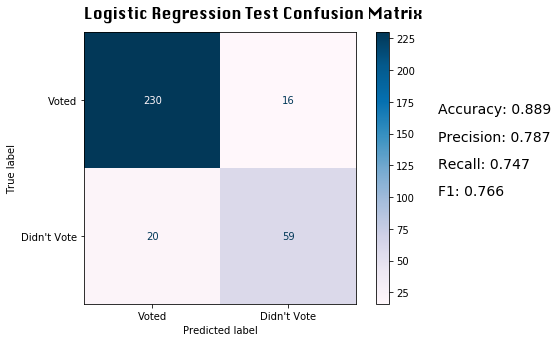

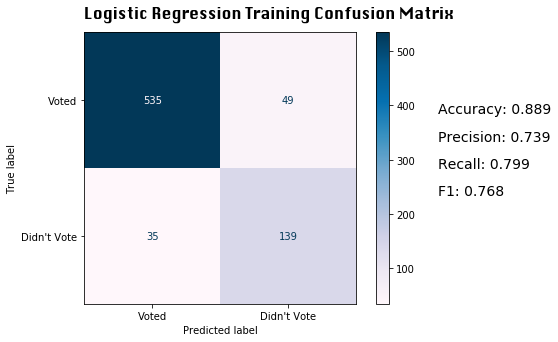

In [59]:
plot_cm(logreg, 'Logistic Regression')

For the test data, the baseline model correctly classified 74% of non-voters in the 2016 election.

#### Optimization

```RandomizedSearchCV``` takes an estimator and a grid of parameters as arguments. It performs a non-exhaustive, random search over the parameters passed in, and returns the model that performs the best on test data. First, we'll define the estimator and the parameters using the following:

-  <b>Standard Scaler:</b> transforms the data such that, in each column, mean=0 and standard deviation=1
-  <b>Principle Component Analysis (PCA):</b> transforms a large set of variables to a smaller set, while trying to account for the maximum amount of variability within each component
-  <b>N-components:</b> number of components in PCA
-  <b>C:</b> inverse of regularization strength (smaller value=stronger regularization)
-  <b>Penalty:</b> Used to specify the norm used in the penalization (L1 or L2 regularization)

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.pipeline import Pipeline
import numpy as np

scl = StandardScaler() 
pca = decomposition.PCA() 
                     

pipeline = Pipeline(steps=[('std_slc', scl),
                           ('pca', pca),
                           ('logreg', logreg)])

param_grid = dict( 
    pca__n_components = list(range(1,X.shape[1]+1,1)),
    logreg__C = list(np.logspace(-3,3,7)), 
    logreg__penalty = ['l1', 'l2'] 
)

In [61]:
from sklearn.model_selection import RandomizedSearchCV
logreg = RandomizedSearchCV(pipeline, param_grid, cv=10, random_state=10)

Next, we'll fit the ```RandomizedSearchCV``` instance to the data.
<br> <b> Note: </b> By default, this process returns errors for combinations of parameters that aren't compatible with logistic regression. These errors can be ignored, because the score for models with incompatible parameters will be set to nan.

In [62]:
import warnings
warnings.filterwarnings('ignore')

logreg_op = logreg.fit(X_train, y_train)

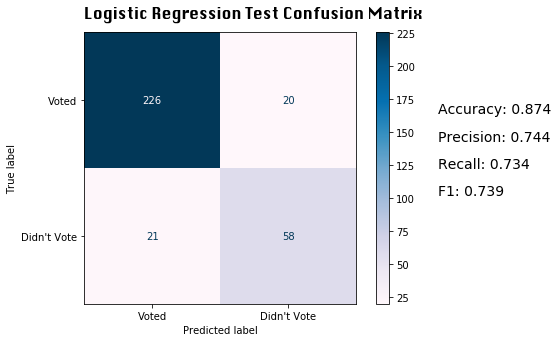

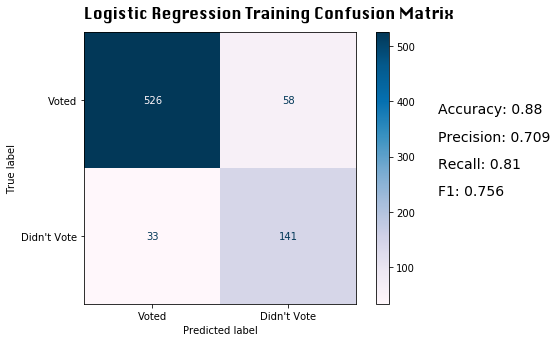

In [63]:
plot_cm(logreg_op, 'Logistic Regression')

With the new parameters, the logistic regression's recall score improved on the training data, but recall performance actually declined on the test data. This model may be overfitted to the training subset.

### Random Forest

The random forest classifier creates a random ensemble of decision trees and makes a prediction based on the total number of "votes" that each class receives. Random forests tend to perform better than individual decision trees by using random samples of observations that prevent overfitting the model to the training data. Reducing overfitting is especially important when working with relatively small datasets.

#### Baseline

In [76]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced", random_state=10).fit(X_train, y_train)

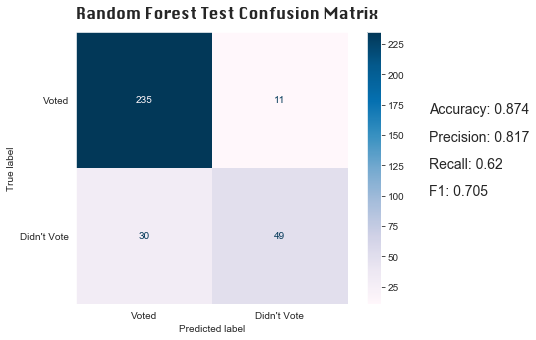

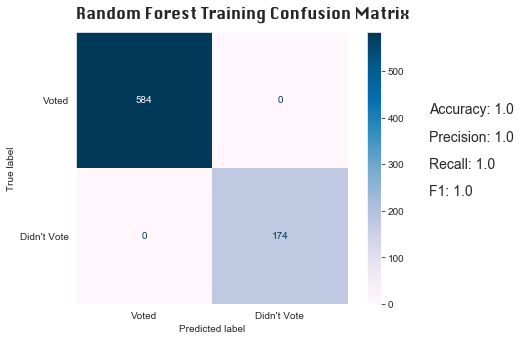

In [77]:
plot_cm(rf, 'Random Forest')

The baseline random forest model correctly classified 62% of non-voters on the test data, and made perfect predictions on the training data.

#### Optimzation

We'll optimize the following parameters in the random forest model:
-  <b>N-estimators:</b> number of trees in the forest
-  <b>Max features:</b> number of features to consider when looking for the best split
-  <b>Max depth:</b> maximum depth of the tree
-  <b>Criterion:</b> how the quality of the split is measured (Gini impurity or entropy for the information gain)

<br>More information on these parameters can be found on the scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) documentation page.

In [78]:
param_grid = { 
    'n_estimators': [100, 200, 300, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,6,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [79]:
rf_op = RandomizedSearchCV(RandomForestClassifier(class_weight="balanced", random_state=10), 
                           param_grid, cv=10, random_state=10)
rf_op.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=10),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 6, 8, 9, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 300, 600]},
                   random_state=10)

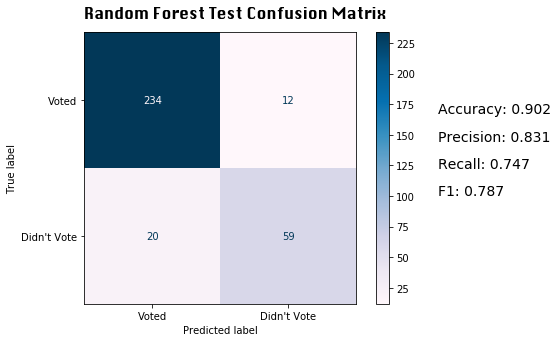

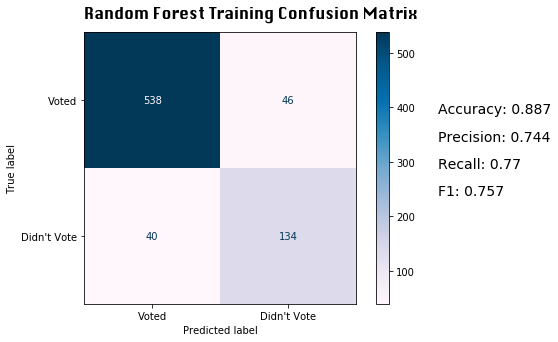

In [68]:
# print(rf_op.best_params_)
plot_cm(rf_op,'Random Forest')

The optimized model performed much better than the baseline model on the test data, and has a recall score that out-performs logistic regression. With non-perfect scores on the training data, we can now be more confident that the model isn't overfitted.

<b> Feature Importances </b>

Random forest models allow us to determine the hierarchy of importance of each of the features. The barplot below displays these feature importances.

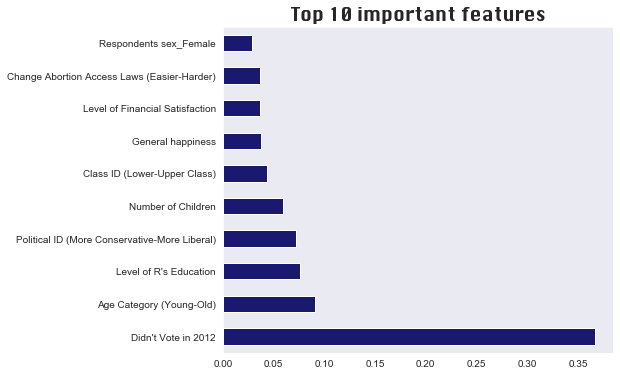

In [80]:
importances = pd.Series(data=rf.fit(X_train, y_train).feature_importances_,index=X.columns)
importances.sort_values(ascending=True,inplace=True)

plt.figure(figsize=(7, 6))
importances.nlargest(10).plot(kind='barh', color='midnightblue')
plt.title("Top 10 important features", fontname='silom', fontsize=18)
plt.show()

The most important features are those that have the highest correlation with 2016 voting, but this graph further illustrates the high importance of past voting behavior.

### Gradient Boosting

As with random forests, decision trees are the fundamental building blocks of a gradient boosting model. Instead of creating random samples, however, each new created tree attempts to correct errors made by the previous tree.

#### Baseline

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=10).fit(X_train, y_train)

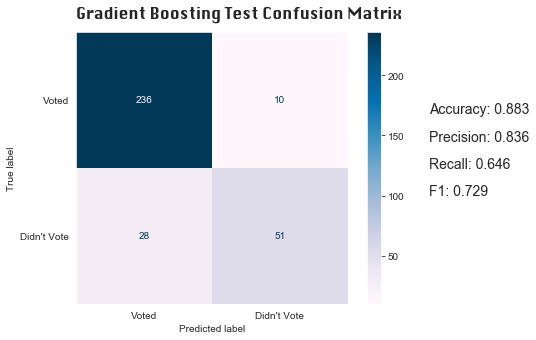

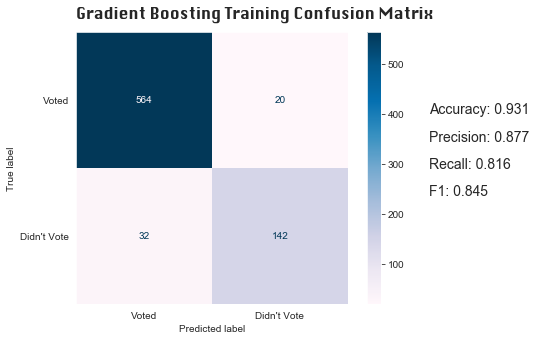

In [82]:
plot_cm(gb, 'Gradient Boosting')

The baseline gradient boosting model correctly classified 51 non-voters on the test data.

#### Optimization

We'll optimize the following parameters in the gradient boosting model:
-  <b>N-estimators:</b> number of boosting stages performed
-  <b>Max depth:</b> maximum depth of individual trees
-  <b>Min samples leaf:</b> minimum number of samples at a leaf node
-  <b>Min samples split:</b> minimum number of samples to split an internal node
-  <b>Max features:</b> number of features to consider when looking for the best split

<br>More information on these parameters can be found on the scikit-learn's [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) documentation page.

In [83]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, .26, 0.3]
n_estimators = [100, 200, 300, 600]
max_depth = [2, 6, 8, 9, 10, 11, 15]
min_samples_leaf = [1, 2, 3, 4, 5, 6] 
min_samples_split = [2, 4, 6, 7, 8, 9, 10]
max_features = ['sqrt', 'log2']

param_grid = {'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

gb_op = RandomizedSearchCV(estimator=gb,
            param_distributions=param_grid,
            cv=10, random_state=10)

In [84]:
gb_op = gb_op.fit(X_train, y_train)

{'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 2, 'learning_rate': 0.1}


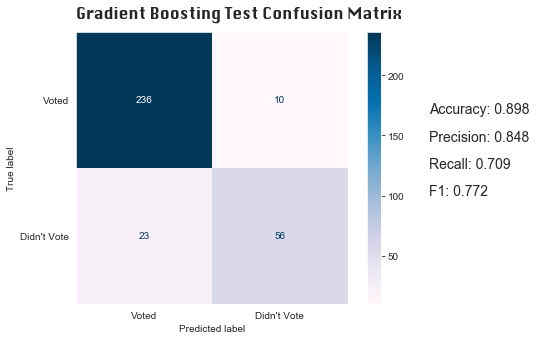

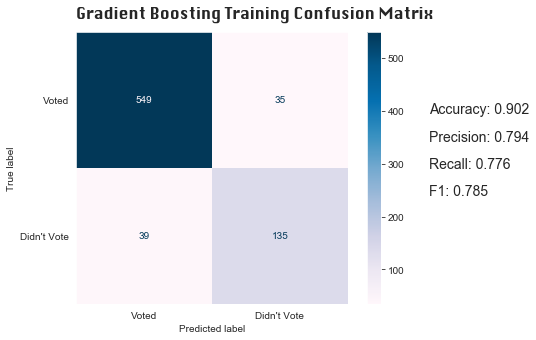

In [85]:
print(gb_op.best_params_)
plot_cm(gb_op, 'Gradient Boosting')

After optimization, the model was able to correctly classify 5 additional non-voters in the test data. The random forest classifier, however, still out-performs it.

## ROC Curve 

Another way to evaluate and compare the performance of these models is an ROC curve. ROC curves plot recall (the true positive rate) against the false positive rate. The Area Under the Curve (AUC) falls between 0 and 1, and a higher area indicates a better-performing model. The code below plots an ROC curve for each of our models, and also displays the recall score alongside it for easy reference.

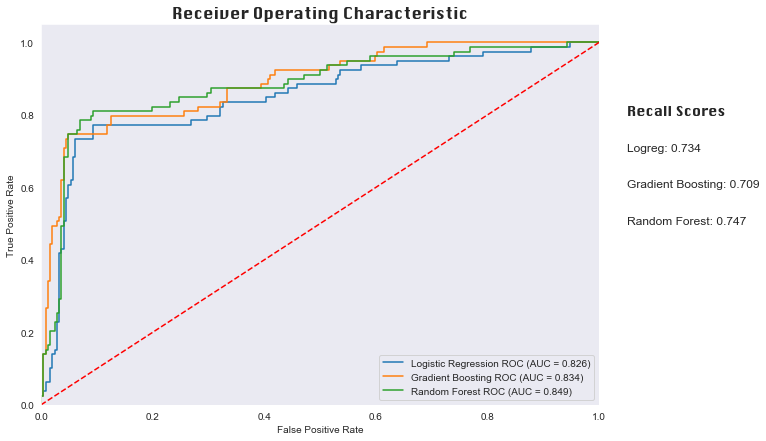

In [86]:
from sklearn import metrics
sns.set_style("dark")

plt.figure(figsize=(10, 7))

models = [
{
    'label': 'Logistic Regression',
    'model': logreg_op,
},

{
    'label': 'Gradient Boosting',
    'model': gb_op,
},

{
    'label': 'Random Forest',
    'model': rf_op,
}
]

for m in models:
    model = m['model'] 
    y_pred=model.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.3f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.text(x=1.05, y=.8, s="Recall Scores",fontsize=14, fontname='silom')
plt.text(x=1.05, y=.6, s="Gradient Boosting: {}".format
         (float(round(recall_score(y_test, gb_op.predict(X_test)), 3))),fontsize=12)
plt.text(x=1.05, y=.5, s="Random Forest: {}".format
         (float(round(recall_score(y_test, rf_op.predict(X_test)), 3))),fontsize=12)
plt.text(x=1.05, y=.7, s="Logreg: {}".format
         (float(round(recall_score(y_test, logreg_op.predict(X_test)), 3))),fontsize=12)

plt.title('Receiver Operating Characteristic', fontsize=16, fontname='silom')
plt.legend(loc="lower right")
plt.show()   

The random forest model has the highest AUC at .84, as well as the highest recall score for the test data. Additionally, the model's results are more interpretable in that they give us a clear understanding of the most important features for making a classification.

## Conclusions and Recommendations

The random forest model, which had the highest AUC and test recall score, is the best-performing classifier overall. Provided with similar data about current eligible voters, the model may be adapted to identify potential non-voters in future elections.

Respondents' participation in the 2012 election was the strongest predictor of voting in the 2016 election, which suggests that past voting behavior may predict an eligible voter's participation in future elections. Political identity was also a strong predictor: respondents who think of themselves as conservative or liberal were more likely to have voted in 2016 than political moderates. Voter turnout rates also appeared to be positively linearly related to age.

With these observations in mind, organizations seeking to increase voter turnout by engaging potential non-voters should prioritize those who haven't voted in past elections, young voters, and political moderates.

## Limitations and Next Steps
Many features were transformed and or excluded from the original dataset to foster a simpler and more legible encoding process. Future analysis should attempt to find or collect more complete data with similar variables. Additionally, models can be further optimized through exhaustive hyperparameter tuning.

## References

[Pipelining: chaining a PCA and a logistic regression](https://scikit-learn.org/0.18/auto_examples/plot_digits_pipe.html)

[Optimizing Hyperparameters of a Logistic Regression Model](https://www.dezyre.com/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python)

[RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomized%20search#sklearn.model_selection.RandomizedSearchCV)

[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression)

[Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boost#sklearn.ensemble.GradientBoostingClassifier)

[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

[Plotting Multiple ROC Curves](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python)